**EJERCICIO 1**


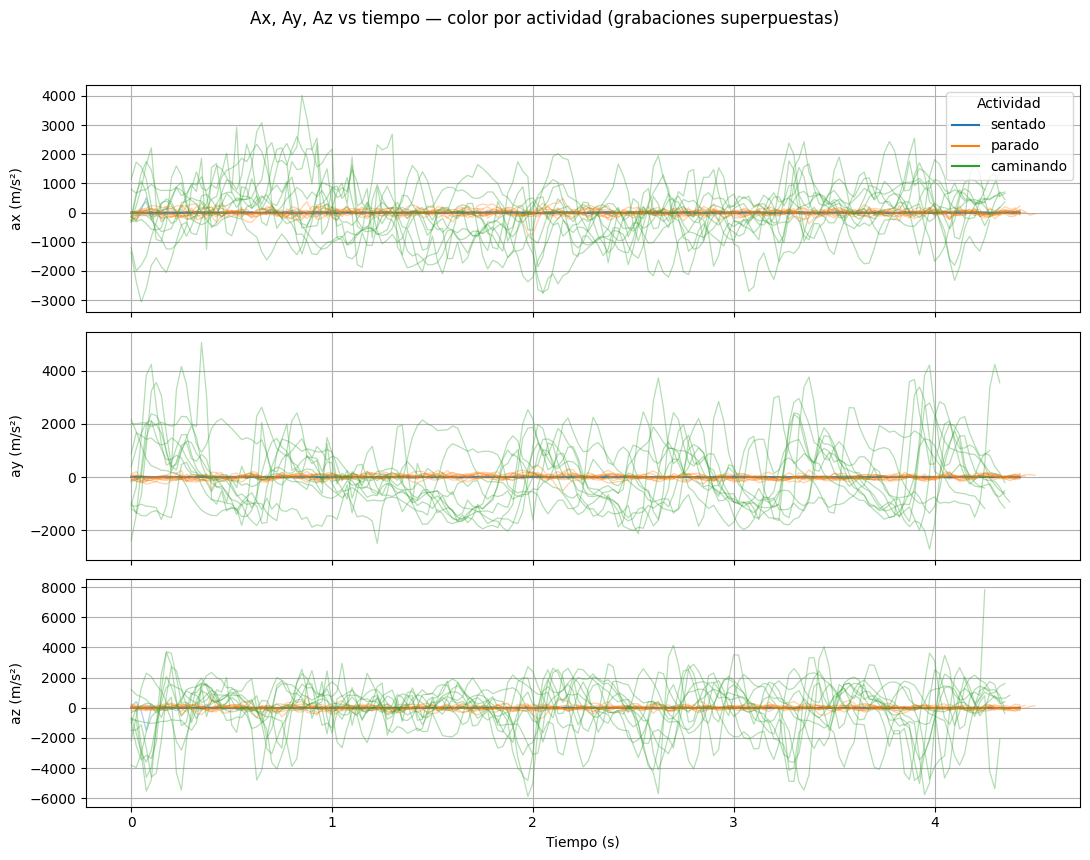

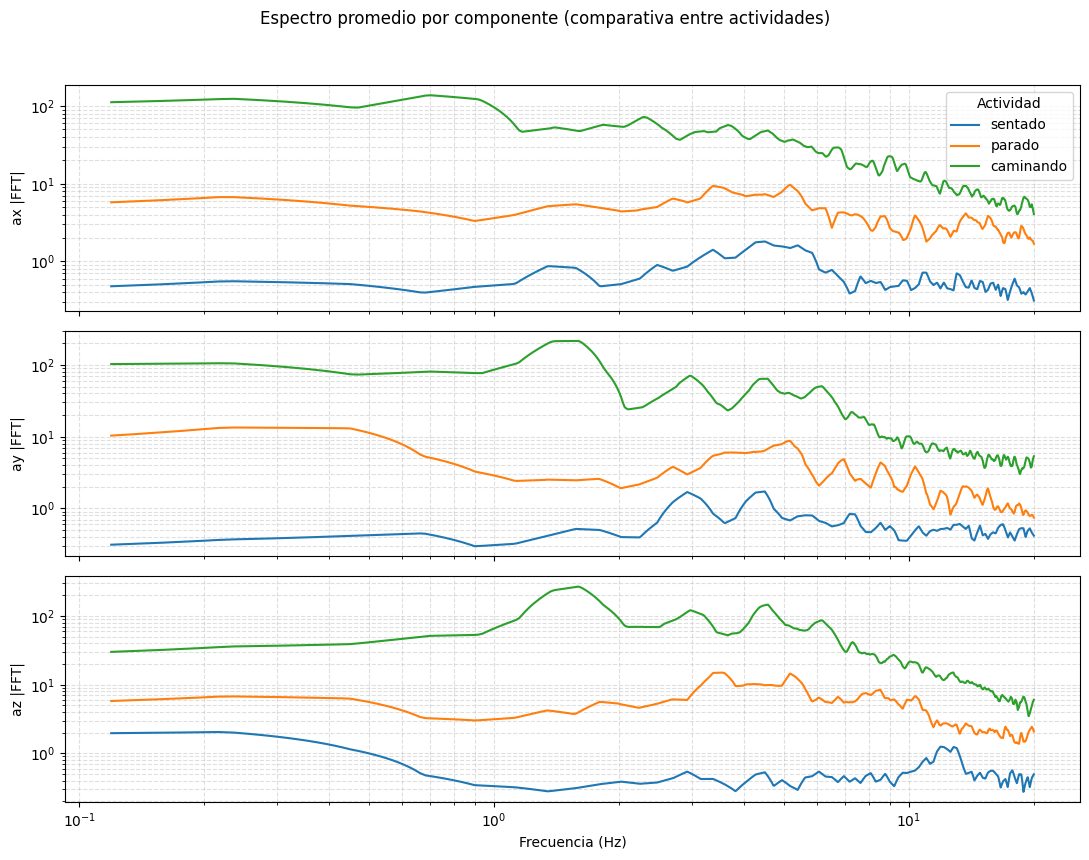

In [4]:
import re
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal


FILES = {
    "sentado": "./sentado.txt",
    "parado": "./parado.txt",
    "caminando": "./caminando.txt",
}
FS = 40.0
ACT_COLORS = {"sentado": "tab:blue", "parado": "tab:orange", "caminando": "tab:green"}


def parse_blocks_from_txt(path: Path):
    text = path.read_text(encoding="utf-8", errors="ignore")
    raw_blocks = re.split(r"(?:\r?\n){2,}", text.strip())
    blocks = []
    for block in raw_blocks:
        lines = [ln.strip() for ln in block.splitlines() if ln.strip()]
        rows = []
        for ln in lines:
            parts = re.split(r"[, \t]+", ln)
            if len(parts) < 3:
                continue
            try:
                rows.append([float(parts[0]), float(parts[1]), float(parts[2])])
            except ValueError:
                continue
        if rows:
            blocks.append(np.array(rows, dtype=float))
    return blocks

def time_vector(n, fs=FS):
    return np.arange(n) / fs

def compute_fft(x, fs=FS):
    n = len(x)
    if n < 2:
        return np.array([0.0]), np.array([0.0])
    win = signal.windows.hann(n)
    yf = np.fft.rfft(x * win)
    yf_mag = np.abs(yf) / n
    xf = np.fft.rfftfreq(n, 1.0/fs)
    return xf, yf_mag

def interp_to_common_grid(spectra_list, fmin=0.1, fmax=None, n_points=1024, fs=FS):
    if fmax is None:
        fmax = fs/2.0
    freqs_common = np.linspace(fmin, fmax, n_points)
    mags_interp = []
    for f, mag in spectra_list:
        try:
            mags_interp.append(np.interp(freqs_common, f, mag))
        except Exception:
            mags_interp.append(np.zeros_like(freqs_common))
    return freqs_common, np.array(mags_interp)


activity_results = {}
for act, fname in FILES.items():
    p = Path(fname)
    if not p.exists():
        print(f"[WARN] Archivo no encontrado: {fname}  -> se omite {act}")
        continue
    blocks = parse_blocks_from_txt(p)
    if not blocks:
        print(f"[WARN] No se encontraron bloques en {fname} -> se omite {act}")
        continue

    recs = []
    spectra = {"ax": [], "ay": [], "az": []}
    for blk in blocks:
        n = blk.shape[0]
        t = time_vector(n, fs=FS)
        ax = signal.detrend(blk[:,0])
        ay = signal.detrend(blk[:,1])
        az = signal.detrend(blk[:,2])
        recs.append({"t": t, "ax": ax, "ay": ay, "az": az})
        fx, ax_mag = compute_fft(ax, fs=FS)
        _, ay_mag = compute_fft(ay, fs=FS)
        _, az_mag = compute_fft(az, fs=FS)
        spectra["ax"].append((fx, ax_mag))
        spectra["ay"].append((fx, ay_mag))
        spectra["az"].append((fx, az_mag))

   
    avg_spectra = {}
    for comp in ("ax","ay","az"):
        f_common, mags = interp_to_common_grid(spectra[comp], fmin=0.1, fmax=FS/2.0, n_points=1024, fs=FS)
        avg_spectra[comp] = (f_common, mags.mean(axis=0))
    activity_results[act] = {"recs": recs, "avg_spectra": avg_spectra}


comps = ["ax","ay","az"]
fig, axs = plt.subplots(3,1, figsize=(11,9), sharex=True)
for act, obj in activity_results.items():
    color = ACT_COLORS.get(act, None)
    for rec in obj["recs"]:
        t = rec["t"]
        for i, comp in enumerate(comps):
            axs[i].plot(t, rec[comp], color=color, alpha=0.35, linewidth=0.9)
for i, comp in enumerate(comps):
    axs[i].set_ylabel(f"{comp} (m/s²)")
    axs[i].grid(True)
axs[-1].set_xlabel("Tiempo (s)")

for act in activity_results:
    axs[0].plot([], [], color=ACT_COLORS.get(act), label=act)  
axs[0].legend(title="Actividad")
fig.suptitle("Ax, Ay, Az vs tiempo — color por actividad (grabaciones superpuestas)")
plt.tight_layout(rect=[0,0.03,1,0.95])
plt.show()


fig, axs = plt.subplots(3,1, figsize=(11,9), sharex=True)
for i, comp in enumerate(comps):
    for act, obj in activity_results.items():
        f, mag = obj["avg_spectra"][comp]
     
        if len(f) > 1:
            axs[i].loglog(f[1:], mag[1:], label=act, color=ACT_COLORS.get(act))
        else:
            axs[i].plot(f, mag, label=act, color=ACT_COLORS.get(act))
    axs[i].set_ylabel(f"{comp} |FFT|")
    axs[i].grid(True, which="both", ls="--", alpha=0.4)
axs[-1].set_xlabel("Frecuencia (Hz)")
axs[0].legend(title="Actividad")
fig.suptitle("Espectro promedio por componente (comparativa entre actividades)")
plt.tight_layout(rect=[0,0.03,1,0.95])
plt.show()



Ejercicio 2

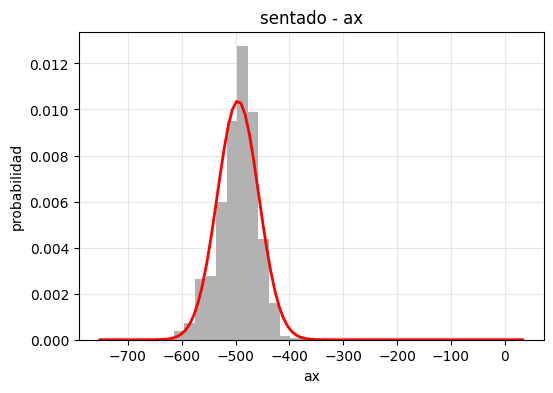

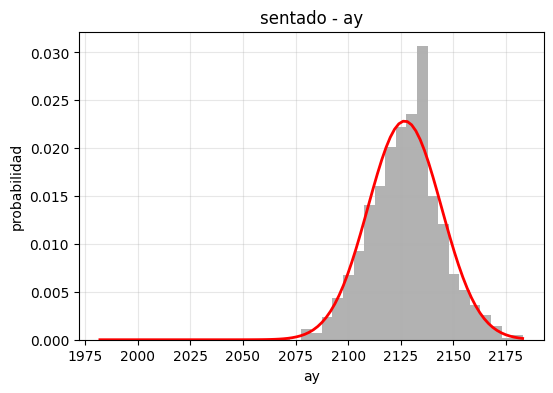

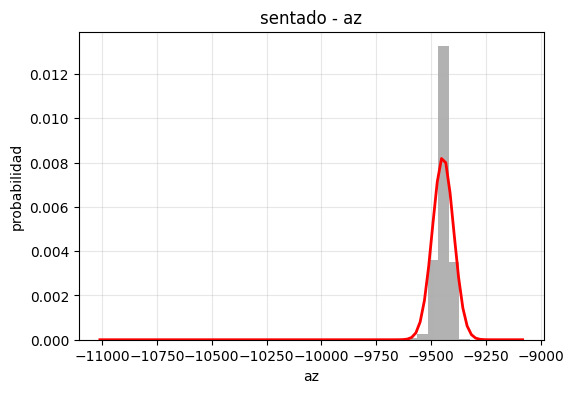

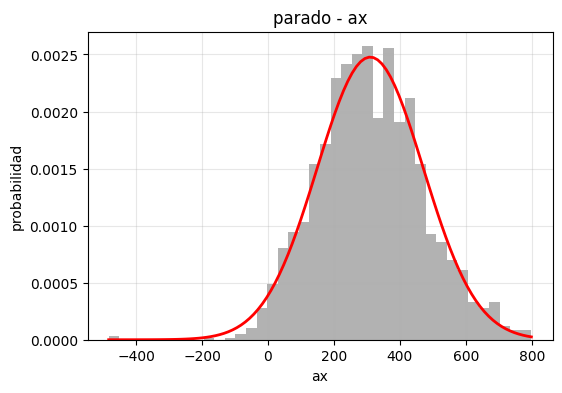

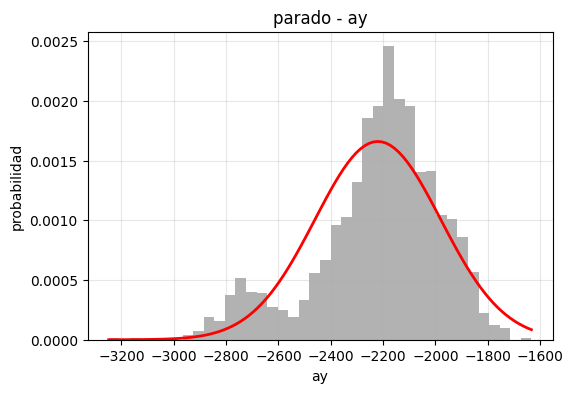

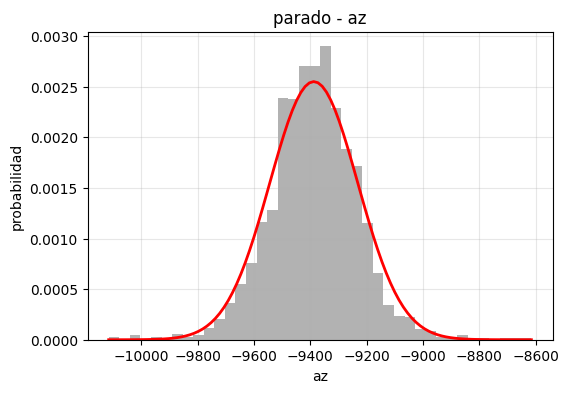

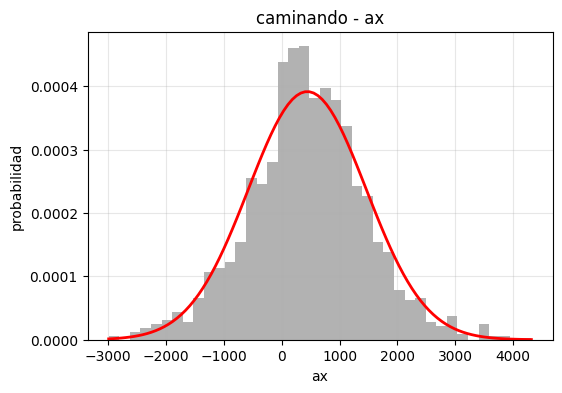

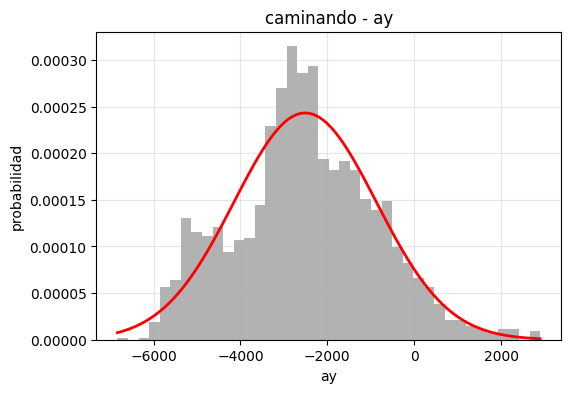

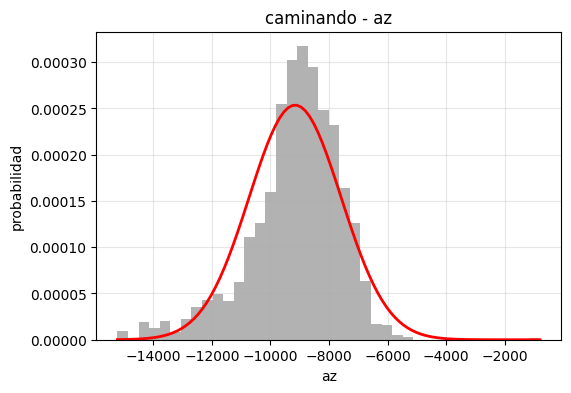

Resultados estadísticos:
sentado
  ax media = -495.54 desviación = 38.45
  ay media = 2126.92 desviación = 17.47
  az media = -9446.55 desviación = 48.25

parado
  ax media = 310.34 desviación = 161.05
  ay media = -2220.04 desviación = 240.33
  az media = -9387.71 desviación = 156.43

caminando
  ax media = 442.93 desviación = 1018.4
  ay media = -2509.1 desviación = 1640.13
  az media = -9157.13 desviación = 1573.07



In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

stats = {}

for act, fname in FILES.items():
    bloques = parse_blocks_from_txt(Path(fname))
    if not bloques:
        continue

    ax_all, ay_all, az_all = [], [], []
    for blk in bloques:
        ax_all.extend(blk[:,0])
        ay_all.extend(blk[:,1])
        az_all.extend(blk[:,2])

    ax_all, ay_all, az_all = map(np.array, (ax_all, ay_all, az_all))

    mu_ax, desv_ax = ax_all.mean(), ax_all.std()
    mu_ay, desv_ay = ay_all.mean(), ay_all.std()
    mu_az, desv_az = az_all.mean(), az_all.std()

    stats[act] = {
        "ax": (mu_ax, desv_ax),
        "ay": (mu_ay, desv_ay),
        "az": (mu_az, desv_az)
    }

    for comp, datos in zip(["ax","ay","az"], [ax_all, ay_all, az_all]):
        mu, desv = stats[act][comp]
        plt.figure(figsize=(6,4))
        plt.hist(datos, bins=40, density=True, alpha=0.6, color="gray")
        x = np.linspace(datos.min(), datos.max(), 100)
        y = norm.pdf(x, mu, desv)
        plt.plot(x, y, "r", linewidth=2)
        plt.title(f"{act} - {comp}")
        plt.xlabel(comp)
        plt.ylabel("probabilidad")  
        plt.grid(True, alpha=0.3)
        plt.show()

print("Resultados estadísticos:")
for act, comps in stats.items():
    print(act)
    for comp, (mu, desv) in comps.items():
        print(" ", comp, "media =", round(mu,2), "desviación =", round(desv,2))
    print()